# K Means Clustering
Online Retails is a transational data set which contains all the transations occuring between 01/12/2010 and 09/12/2011 for a UK-based and registered nonstore  online retail. The company mainly sales unique all-occasion gifts. Many customer of the company are wholesaler.

# What actually we want ?
Segment the Customers based on RFM so that the company can target its customers.

## R (Recency) : Number of days since last Purchage
## F (Frequency): Number of transaction 
## M (Monetary) : Total amount of transations (revanue contributed)

### Import Data From SQL Srver Using Pyodbc

In [1]:
import pyodbc
import pandas as pd

# Create Connection String and Connect by using Pyodbc
cnxn_str = ('Driver={SQL Server};' 
            "Server={LAPTOP-DMS3CURR};"
            "Database={sales};"
            "Trusted_connection=yes;")

cnn = pyodbc.connect(cnxn_str)


In [2]:

# Run SQL and load dataset          
sql_query = pd.read_sql('SELECT * FROM Online_Retail', cnn)

# convert into dataframe
data = pd.DataFrame(sql_query)


# Initial data exploration
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
data.shape

(406829, 8)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 24.8+ MB


## Data Cleaning

In [5]:
# Calculationg missing value % cuntributing in DF 
df_null = round(100*(data.isnull().sum())/len(data),2)
df_null

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [6]:
# Droping rows having missing values 
data= data.dropna()
data.shape

(406829, 8)

In [7]:
# changing the data type of customer id

data['CustomerID'] = data['CustomerID'].astype(str)

In [8]:
# New Attributes : Monetory

data['amount'] = data['Quantity']*data['UnitPrice']
rfm_m = data.groupby('CustomerID')['amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,amount
0,12346,0.000000
1,12347,4309.999988
2,12348,1797.239997
3,12349,1757.549994
4,12350,334.399997


In [9]:
# New Attributes: Frequency 

rfm_f = data.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346,2
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [10]:
# Merging two dataframes
rfm_p = pd.merge(rfm_m , rfm_f , on= 'CustomerID' , how = 'inner' )
rfm_p.head()

,CustomerID,amount,Frequency
0,12346,0.000000,2
1,12347,4309.999988,182
2,12348,1797.239997,31
3,12349,1757.549994,73
4,12350,334.399997,17


In [11]:
# Compute the maximum date to know the last transition date 

max_date = max(data['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [12]:
# Compure the diffrence between the maximum data and transaction date

data["Date_Diff"] = max_date - data["InvoiceDate"]
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Date_Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.300000,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.340001,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.000000,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.340001,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.340001,373 days 04:24:00


In [13]:
# Compute recency of Customer 

rfm_r = data.groupby('CustomerID')['Date_Diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r.head()

,CustomerID,Date_Diff
0,12346,325 days 02:33:00
1,12347,1 days 20:58:00
2,12348,74 days 23:37:00
3,12349,18 days 02:59:00
4,12350,309 days 20:49:00


In [14]:
# Extract recency in Number of days only 

rfm_r['Day_diff'] = rfm_r["Date_Diff"].dt.days
rfm_r = rfm_r.drop(['Date_Diff'], axis=1)
rfm_r.head()

,CustomerID,Day_diff
0,12346,325
1,12347,1
2,12348,74
3,12349,18
4,12350,309


In [15]:
# Merge the dataframe to get the finam RFM dataframe 

rfm = pd.merge(rfm_p, rfm_r , on = 'CustomerID', how = 'inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346,0.000000,2,325
1,12347,4309.999988,182,1
2,12348,1797.239997,31,74
3,12349,1757.549994,73,18
4,12350,334.399997,17,309


In [16]:
rfm.shape

(4372, 4)

Text(0.5, 0, 'Attributes')

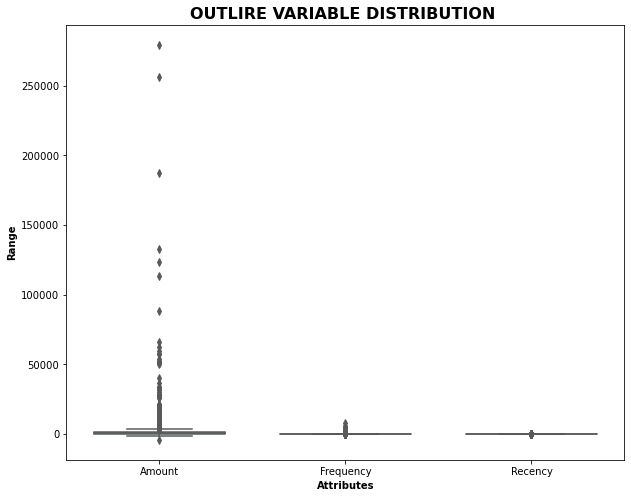

In [17]:
# Outlier Analysis of Amount Frequency and Recency
import matplotlib.pyplot as plt 
import seaborn as sns
attributes = ['Amount' ,'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient = 'v', palette= 'Set2' , whis=1.5, saturation = 1, width = 0.7)
plt.title("OUTLIRE VARIABLE DISTRIBUTION ", fontsize = 16, fontweight ='bold')
plt.ylabel('Range', fontweight ='bold')
plt.xlabel('Attributes', fontweight ='bold')

### Removing Outliers

In [18]:
# From Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3-Q1 
rfm = rfm[(rfm.Amount >=Q1 - 1.5*IQR)&(rfm.Amount <=Q3 + 1.5*IQR)]

# From Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3-Q1 
rfm = rfm[(rfm.Recency >=Q1 - 1.5*IQR)&(rfm.Recency <=Q3 + 1.5*IQR)]

# From Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3-Q1 
rfm = rfm[(rfm.Frequency >=Q1 - 1.5*IQR)&(rfm.Frequency <=Q3 + 1.5*IQR)]

## Scalling And Feature Engineering

In [19]:
from sklearn.preprocessing import StandardScaler
rfm_df = rfm[['Amount' ,'Frequency', 'Recency']]

# Instantiate
Scaler = StandardScaler()

#fit_transform 
rfm_df_scaled = Scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [20]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)

rfm_df_scaled.columns = ['Amount' ,'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## Model Building 

In [21]:
# Use k-means cluster model 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, max_iter= 50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [22]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [23]:
set(kmeans.labels_)

{0, 1, 2, 3}

## Elbow Curve to get the right number of Clusters

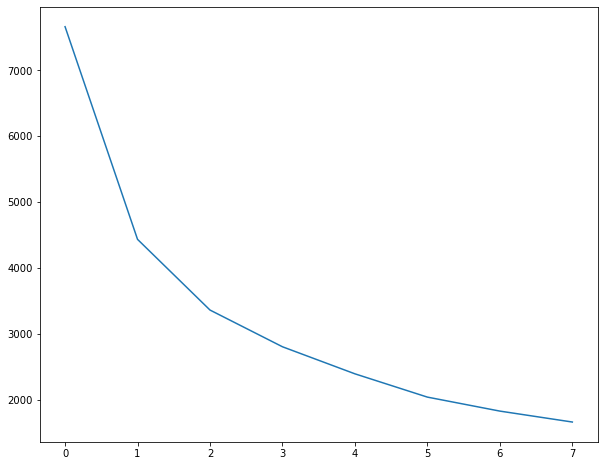

In [24]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8,9]
for num_cluster in range_n_clusters :
    kmeans = KMeans(n_clusters=num_cluster, max_iter= 50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters 
plt.plot(ssd)

### Optimum Number Of Cluster = 3

## Training The K-Means Clustering Model 

In [25]:
# Final Model with K=3
kmeans = KMeans(n_clusters=3, max_iter= 50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [26]:
# save this value in a variable and create array
Cluster= kmeans.fit_predict(rfm_df_scaled)

In [27]:
# Add this column in rfm dataset and how the full result
result=rfm
result['Cluster']=Cluster

In [28]:
result.head()

,CustomerID,Amount,Frequency,Recency,Cluster
0,12346,0.000000,2,325,0
1,12347,4309.999988,182,1,1
2,12348,1797.239997,31,74,2
3,12349,1757.549994,73,18,2
4,12350,334.399997,17,309,0


## Visualizing All the Clusters

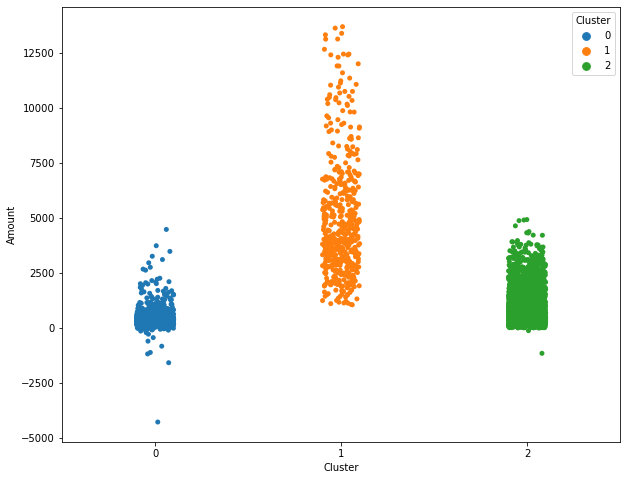

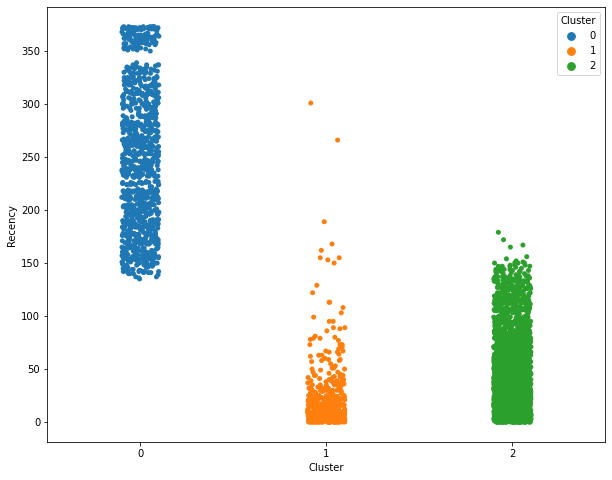

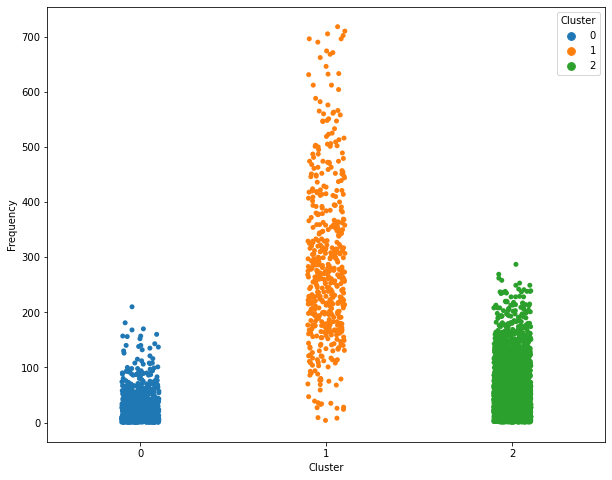

In [29]:
import seaborn as sns
# Amount
sns.stripplot(x='Cluster',y='Amount', data = result , hue='Cluster')
plt.show()

# Recency
sns.stripplot(x='Cluster',y='Recency', data = result , hue='Cluster')
plt.show()

# Frequency 
sns.stripplot(x='Cluster',y='Frequency', data = result , hue='Cluster')
plt.show()

# Conclusion 

Cluster 0 Group : Avrage For All Condition 

Cluster 1 Group : (i) High Recency
                  (ii) It Has Minimum Frequency 
                  (iii)It has Min Amount spend 
                
Cluster 2 Group : (i) They Spend High amount of money 
                  (ii) It Has High Frequency 
                  (iii)It has Min recency

# Save Model And Result File 

In [30]:
#Save The Model 
import pickle
pickle.dump(kmeans,open('kmean_model.pkl','wb'))

In [31]:
# Save the result File in CSV
result.to_csv('result.csv',index=False)